In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.float_format = "{:.4f}".format
from copy import deepcopy
import tempfile
import phik
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
DIR_PATH = '/kaggle/input/home-credit-default-risk/'
OUTPUT_DIR = '/kaggle/working/'

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
def get_unique_categaories(df):
    # Number of unique classes in each object column
    return df.select_dtypes('category').apply(pd.Series.nunique, axis = 0)

In [3]:
def one_hot_encoder(df, nan_as_category = False, category_type = 'category'):
    '''
    Function to do one-hot encoding for categorical columns with get_dummies
    
    Input:
        df: Dataframe
            Input dataframe
        nan_as_category: bool, default = False
            Treat NaN as a category
        
    '''
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == category_type]
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


In [5]:
def get_features_of_type(df, is_categorical = True):
    
    return [col for col in list(df.columns) if df[col].dtype == 'category'] if is_categorical else [col for col in list(df.columns) if df[col].dtype != 'category']

In [6]:
def save_file(df, file_name, as_csv = True, remove_old_file= True):
    file_name = file_name or next(tempfile._get_candidate_names())
    extension = '.csv' if as_csv  else '.pkl'
    
    file_name = OUTPUT_DIR + file_name + extension
    if os.path.isfile(file_name):
        print("### File exists ! ###")
        if not remove_old_file:
            return None
        print("### Removing {} ###".format(file_name))
        os.remove(file_name)
        
    if as_csv:
        df.to_csv(file_name, encoding='utf-8')
    else:
        df.to_pickle(file_name)
    print("Saved {}...".format(file_name))

In [7]:
def reduce_mem_usage(df):
    """ Function to iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.  
        Input: dataframe
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

get_features_of_typeSome helpful utility functions

In [8]:
def read_input_file(directory_path = DIR_PATH, fileName= 'application_train', displayHead = True, 
                    displayInfo = True, displayStats = True, num_rows = None, verbose=True, saveFile = True):
    '''
    Function to load the given input table
    
    Input:
        directory_path: str, default = DIR_PATH
            Path of directory in which table is stored
        fileName: str, default = application_train.csv
            Name of csv file containing the table
        displayHead: bool, default = True
            Display head for pandas dataframe
        displayInfo: bool, default = True
            Display info for pandas dataframe
        displayStats: bool, default = True
            Describe function for pandas dataframe
        num_rows: int, default = None
            Limit pandas read for debug mode or dry run
        verbose: bool, default = True
            Whether to keep verbosity or not
    '''
        
    df = pd.read_csv(directory_path + fileName +'.csv', nrows= num_rows)
    df = reduce_mem_usage(df)
    if verbose:
        print("Loaded {}... Dataframe contains {}".format(fileName, len(df)))
    if displayHead:
        display(df.head())
    if displayInfo:
        display(df.info(verbose=True, show_counts = True))
    if displayStats:
        display(df.describe().T)
    if saveFile:
        save_file(df, fileName)
        
    return df

In [9]:
def get_nan_percentage(data, filter_not_nans = True):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Input:
        data: DataFrame
   
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    if filter_not_nans:
        df = df[df.percent > 0]
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [10]:
df = read_input_file()
display(get_nan_percentage(df))


print(df.select_dtypes('category').apply(pd.Series.nunique, axis = 0))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Loaded application_train... Dataframe contains 307511


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6191,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6343,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6245,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6221,NaN,0.0959,0.0529,0.9849,0.7959,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9849,0.8042,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9849,0.7988,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.5562,0.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype   
---   ------                        --------------   -----   
 0    SK_ID_CURR                    307511 non-null  int32   
 1    TARGET                        307511 non-null  int8    
 2    NAME_CONTRACT_TYPE            307511 non-null  category
 3    CODE_GENDER                   307511 non-null  category
 4    FLAG_OWN_CAR                  307511 non-null  category
 5    FLAG_OWN_REALTY               307511 non-null  category
 6    CNT_CHILDREN                  307511 non-null  int8    
 7    AMT_INCOME_TOTAL              307511 non-null  float32 
 8    AMT_CREDIT                    307511 non-null  float32 
 9    AMT_ANNUITY                   307499 non-null  float32 
 10   AMT_GOODS_PRICE               307233 non-null  float32 
 11   NAME_TYPE_SUITE               306219 non-null  category
 12   NAME_INCOME_TY

None

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0000,278180.5186,102790.1753,100002.0000,189145.5000,278202.0000,367142.5000,456255.0000
TARGET,307511.0000,0.0807,0.2724,0.0000,0.0000,0.0000,0.0000,1.0000
CNT_CHILDREN,307511.0000,0.4171,0.7221,0.0000,0.0000,0.0000,1.0000,19.0000
AMT_INCOME_TOTAL,307511.0000,168797.9219,237123.1406,25650.0000,112500.0000,147150.0000,202500.0000,117000000.0000
AMT_CREDIT,307511.0000,599025.9375,402490.7812,45000.0000,270000.0000,513531.0000,808650.0000,4050000.0000
AMT_ANNUITY,307499.0000,27108.5723,14493.7373,1615.5000,16524.0000,24903.0000,34596.0000,258025.5000
AMT_GOODS_PRICE,307233.0000,538396.1250,369446.4688,40500.0000,238500.0000,450000.0000,679500.0000,4050000.0000
REGION_POPULATION_RELATIVE,307511.0000,0.0000,0.0000,0.0003,0.0100,0.0188,0.0287,0.0725
DAYS_BIRTH,307511.0000,-16036.9951,4363.9886,-25229.0000,-19682.0000,-15750.0000,-12413.0000,-7489.0000
DAYS_EMPLOYED,307511.0000,63815.0459,141275.7665,-17912.0000,-2760.0000,-1213.0000,-289.0000,365243.0000


Saved /kaggle/working/application_train.csv...


,column,percent
76,COMMONAREA_MEDI,69.8723
48,COMMONAREA_AVG,69.8723
62,COMMONAREA_MODE,69.8723
84,NONLIVINGAPARTMENTS_MEDI,69.4330
70,NONLIVINGAPARTMENTS_MODE,69.4330
56,NONLIVINGAPARTMENTS_AVG,69.4330
86,FONDKAPREMONT_MODE,68.3862
68,LIVINGAPARTMENTS_MODE,68.3550
82,LIVINGAPARTMENTS_MEDI,68.3550
54,LIVINGAPARTMENTS_AVG,68.3550


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


In [11]:
target_val_counts = df.TARGET.value_counts(normalize=False)
print(target_val_counts)

0    282686
1     24825
Name: TARGET, dtype: int64


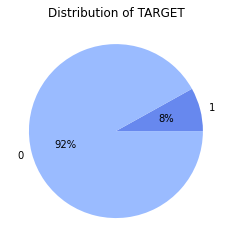

In [12]:
#target_val_ratio = df.TARGET.value_counts(normalize=True)
keyNames = ['1', '0',]
data_dict = target_val_counts.to_dict()
data = [data_dict[int(x)] for x in keyNames] 
# define Seaborn color palette to use
palette_color = sns.color_palette('coolwarm')
# plotting data on chart
plt.pie(data, labels=keyNames, colors=palette_color, autopct='%.0f%%')
plt.title("Distribution of TARGET")
# displaying chart
plt.show()

In [13]:
def plot_heatmap(df, annot = False, cmap = 'YlOrBr', xticks_rota = 90, yticks_rota = 0, fontsize = 10, plot_title = None,  figsize = None, mask_upper=True ):
    if mask_upper:
        mask_array = np.ones(df.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(df.shape)
        
    if figsize:
         plt.figure(figsize = figsize)
    sns.heatmap(df, annot = annot,  cmap = cmap, mask = mask_array)
    plt.xticks(rotation = xticks_rota, fontsize = fontsize)
    plt.yticks(rotation = yticks_rota, fontsize = fontsize)
    if plot_title:
        plt.title(plot_title)
    plt.show()

In [14]:
    
def plot_categroical_variables(df, include_target = True, plot_title = "Phi-K Correlation Heatmap for Categorical Features"):
    #import dill as pickle
    #from phik import report
    #rep = report.correlation_report(df, significance_threshold=3, correlation_threshold=0.2)
    categoricalColumns = [ col for col in df.columns if df[col].dtype == 'category']
    if include_target:
        categoricalColumns.append('TARGET')
    data_for_phik = df[categoricalColumns].astype('object')
    df_phik_matrix = data_for_phik.phik_matrix()
    
    
    plot_heatmap(df_phik_matrix, plot_title = plot_title)
    display(df_phik_matrix)
    """
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    """

In [15]:
display(get_unique_categaories(df))

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
df.CODE_GENDER.unique()
display(df.CODE_GENDER.value_counts())

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [17]:
 #df = df[df['CODE_GENDER'] != 'XNA'] ## optional step ##

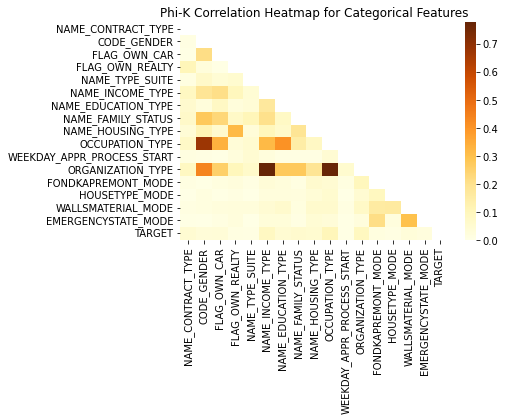

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,TARGET
NAME_CONTRACT_TYPE,1.0000,0.0084,0.0056,0.1053,0.0133,0.0823,0.0550,0.0669,0.0373,0.0711,0.0133,0.0834,0.0092,0.0000,0.0114,0.0036,0.0484
CODE_GENDER,0.0084,1.0000,0.2111,0.0267,0.0676,0.1870,0.0248,0.2754,0.1130,0.6724,0.0082,0.4381,0.0059,0.0162,0.0160,0.0008,0.0329
FLAG_OWN_CAR,0.0056,0.2111,1.0000,0.0034,0.0402,0.2090,0.0792,0.2334,0.0558,0.3354,0.0048,0.2535,0.0178,0.0059,0.0235,0.0092,0.0342
FLAG_OWN_REALTY,0.1053,0.0267,0.0034,1.0000,0.0536,0.0951,0.0247,0.0717,0.3128,0.0338,0.0228,0.0973,0.0233,0.0093,0.0245,0.0220,0.0092
NAME_TYPE_SUITE,0.0133,0.0676,0.0402,0.0536,1.0000,0.0408,0.0368,0.1060,0.0320,0.0488,0.0467,0.0664,0.0080,0.0023,0.0263,0.0017,0.0087
NAME_INCOME_TYPE,0.0823,0.1870,0.2090,0.0951,0.0408,1.0000,0.1689,0.2025,0.0989,0.3131,0.0234,0.7759,0.0341,0.0242,0.0436,0.0289,0.0848
NAME_EDUCATION_TYPE,0.0550,0.0248,0.0792,0.0247,0.0368,0.1689,1.0000,0.0783,0.0624,0.4035,0.0086,0.2735,0.0254,0.0238,0.0590,0.0280,0.0470
NAME_FAMILY_STATUS,0.0669,0.2754,0.2334,0.0717,0.1060,0.2025,0.0783,1.0000,0.1851,0.1468,0.0077,0.2755,0.0095,0.0201,0.0159,0.0068,0.0560
NAME_HOUSING_TYPE,0.0373,0.1130,0.0558,0.3128,0.0320,0.0989,0.0624,0.1851,1.0000,0.0811,0.0069,0.1862,0.0562,0.0384,0.0605,0.0408,0.0511
OCCUPATION_TYPE,0.0711,0.6724,0.3354,0.0338,0.0488,0.3131,0.4035,0.1468,0.0811,1.0000,0.0435,0.7702,0.0481,0.0532,0.0597,0.0332,0.1028


In [18]:
plot_categroical_variables(df)

In [19]:
def corrFilter(x, bound):
    x = deepcopy(x)
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened


In [20]:
    
def plot_numerical_variables(df, figsize = (30,20), display_significant_corrs = True, file_name = None, save_as_csv = True):
    
    numericalColumns = [ col for col in df.columns if df[col].dtype != 'category']
    ### Avoid value errors due to string values not handled by corr ###
    df = df[numericalColumns]
    df_corr = df.corr()
    if save_as_csv:
        save_file(df_corr, file_name)
    plot_title = "Correlation Heatmap for Numerical Features"
    plot_heatmap(df_corr, plot_title = plot_title, figsize = figsize, cmap = 'crest')
    #dfn = drop_corr_noise(df)
    #plot_heatmap(dfn, plot_title = plot_title, figsize = figsize, cmap = 'crest')
    display(df_corr)
    print("Top Numerical Correlations")
    display(corrFilter(df, .4))
   


Saved /kaggle/working/i6a9gcu2.csv...


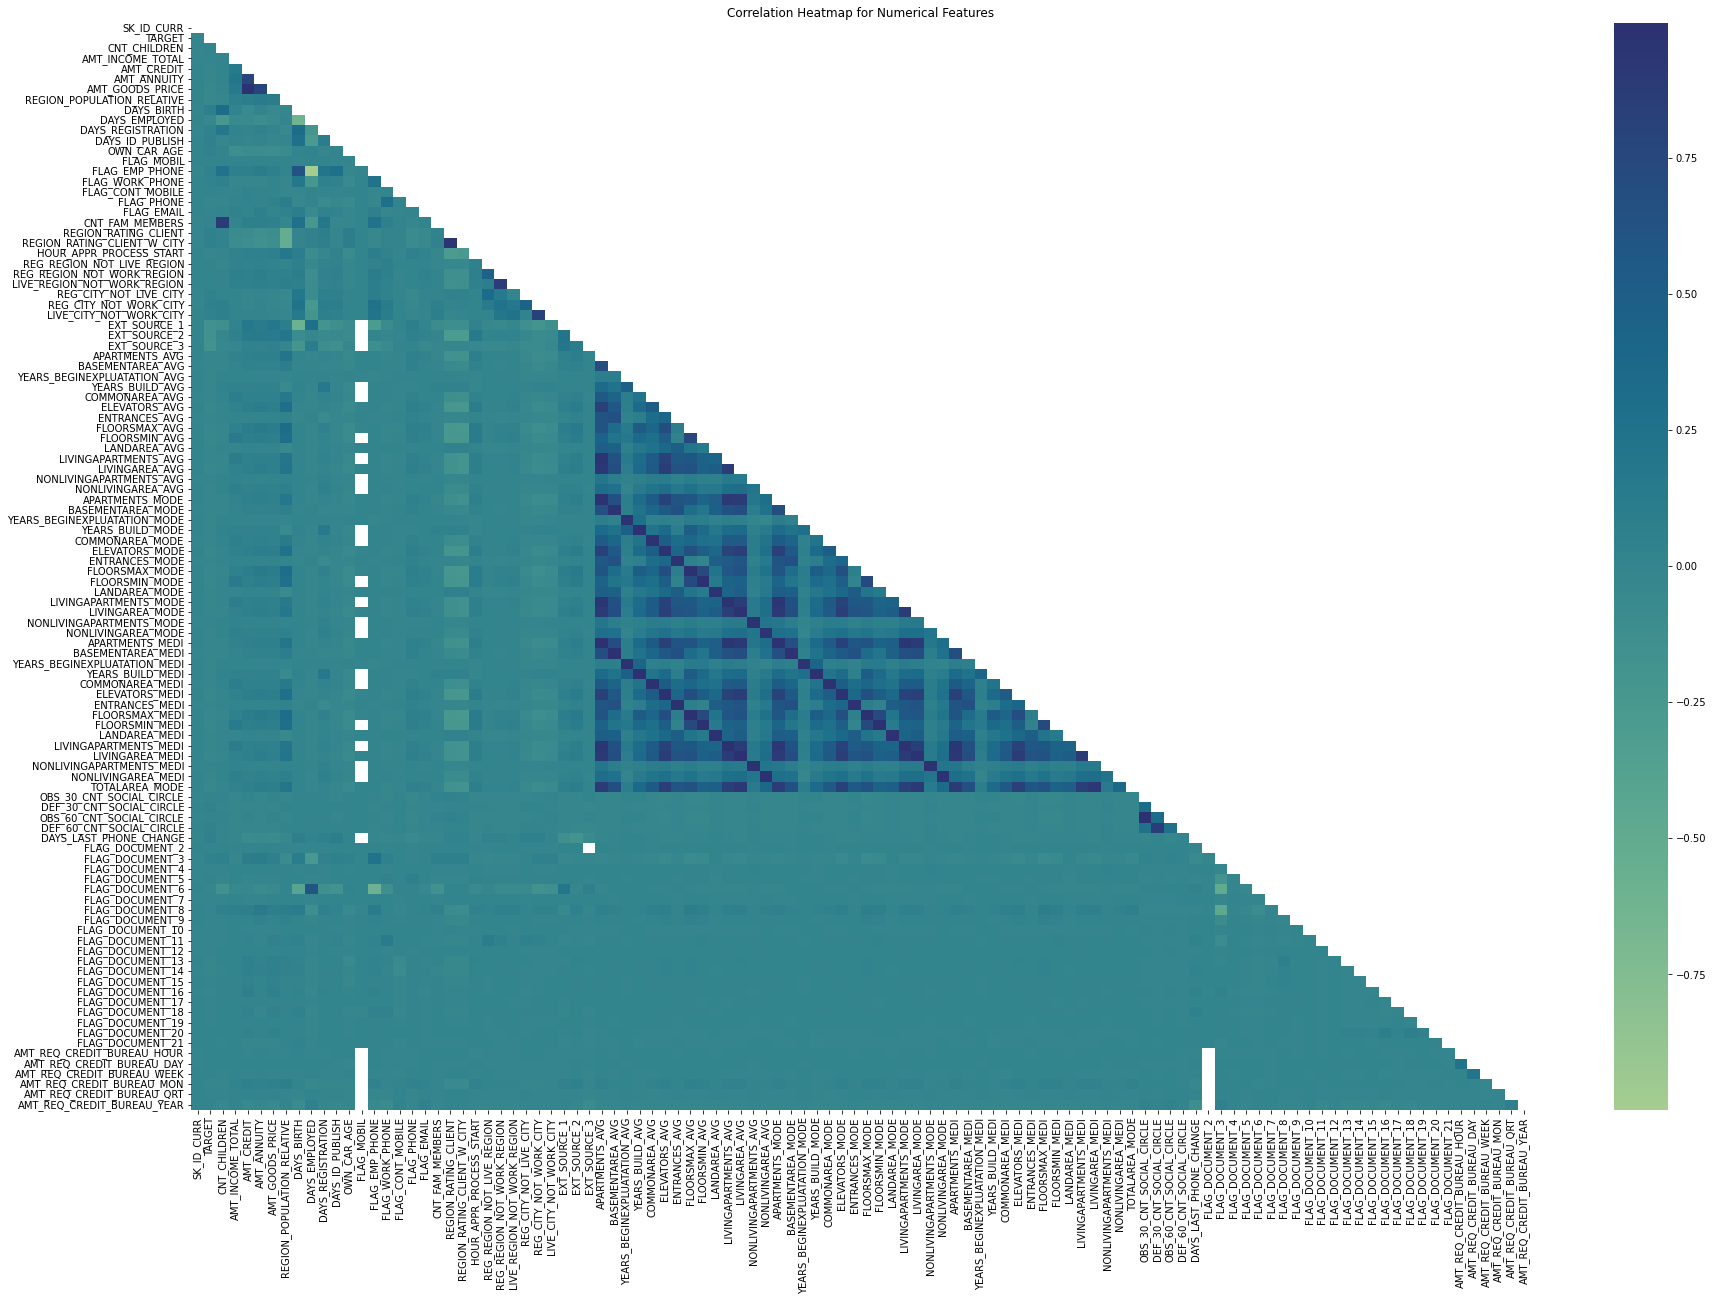

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.0000,-0.0021,-0.0011,-0.0018,-0.0003,-0.0004,-0.0002,0.0008,-0.0015,0.0014,-0.0010,-0.0004,0.0018,0.0028,-0.0013,-0.0004,0.0028,0.0028,0.0003,-0.0029,-0.0011,-0.0011,0.0004,-0.0003,0.0011,0.0029,-0.0019,-0.0016,0.0001,0.0001,0.0023,0.0002,0.0016,-0.0021,0.0016,0.0059,-0.0015,0.0049,-0.0029,0.0049,0.0031,0.0015,0.0031,0.0018,-0.0026,0.0030,0.0020,-0.0014,0.0019,0.0052,-0.0011,0.0050,-0.0028,0.0044,0.0021,0.0015,0.0036,0.0022,-0.0019,0.0019,0.0020,-0.0016,0.0014,0.0058,-0.0010,0.0051,-0.0026,0.0046,0.0028,0.0017,0.0033,0.0022,-0.0030,0.0024,0.0023,-0.0014,-0.0001,-0.0014,0.0012,-0.0009,0.0007,-0.0034,-0.0041,-0.0011,0.0021,-0.0027,0.0018,0.0015,-0.0008,-0.0020,-0.0010,0.0009,-0.0011,0.0026,-0.0007,0.0014,0.0005,0.0002,0.0011,0.0003,-0.0027,-0.0022,0.0021,0.0005,0.0010,0.0047
TARGET,-0.0021,1.0000,0.0192,-0.0040,-0.0304,-0.0128,-0.0396,-0.0372,0.0782,-0.0449,0.0420,0.0515,0.0376,0.0005,0.0460,0.0285,0.0004,-0.0238,-0.0018,0.0093,0.0589,0.0609,-0.0242,0.0056,0.0069,0.0028,0.0444,0.0510,0.0325,-0.1553,-0.1605,-0.1789,-0.0295,-0.0227,-0.0098,-0.0222,-0.0185,-0.0342,-0.0192,-0.0440,-0.0336,-0.0109,-0.0250,-0.0330,-0.0032,-0.0136,-0.0273,-0.0200,-0.0091,-0.0221,-0.0163,-0.0321,-0.0174,-0.0432,-0.0327,-0.0102,-0.0234,-0.0307,-0.0016,-0.0127,-0.0292,-0.0221,-0.0100,-0.0223,-0.0186,-0.0339,-0.0190,-0.0438,-0.0334,-0.0113,-0.0246,-0.0327,-0.0028,-0.0133,-0.0326,0.0091,0.0322,0.0090,0.0313,0.0552,0.0054,0.0443,-0.0027,-0.0003,-0.0286,-0.0015,-0.0080,-0.0044,-0.0014,-0.0042,-0.0008,-0.0116,-0.0095,-0.0065,-0.0116,-0.0034,-0.0080,-0.0014,0.0002,0.0037,0.0009,0.0027,0.0008,-0.0125,-0.0020,0.0199
CNT_CHILDREN,-0.0011,0.0192,1.0000,0.0129,0.0021,0.0214,-0.0018,-0.0256,0.3309,-0.2398,0.1834,-0.0280,0.0085,0.0010,0.2407,0.0556,-0.0008,-0.0299,0.0226,0.8792,0.0254,0.0248,-0.0073,-0.0133,0.0082,0.0148,0.0201,0.0706,0.0700,-0.1385,-0.0180,-0.0427,-0.0132,-0.0085,0.0069,0.0302,0.0001,-0.0071,-0.0083,-0.0097,-0.0088,-0.0031,-0.0086,-0.0101,0.0041,0.0000,-0.0121,-0.0085,0.0062,0.0296,0.0004,-0.0064,-0.0069,-0.0096,-0.0080,-0.0022,-0.0080,-0.0095,0.0041,0.0002

Top Numerical Correlations


FLAG_EMP_PHONE                DAYS_EMPLOYED                  -0.9998
DAYS_BIRTH                    DAYS_EMPLOYED                  -0.6159
EXT_SOURCE_1                  DAYS_BIRTH                     -0.6006
FLAG_DOCUMENT_6               FLAG_EMP_PHONE                 -0.5977
REGION_RATING_CLIENT          REGION_POPULATION_RELATIVE     -0.5329
REGION_RATING_CLIENT_W_CITY   REGION_POPULATION_RELATIVE     -0.5316
FLAG_DOCUMENT_3               FLAG_DOCUMENT_6                -0.4862
FLAG_DOCUMENT_8               FLAG_DOCUMENT_3                -0.4657
FLAG_DOCUMENT_6               DAYS_BIRTH                     -0.4072
COMMONAREA_MEDI               FLOORSMAX_MEDI                  0.4014
ENTRANCES_MEDI                ELEVATORS_AVG                   0.4017
ENTRANCES_MODE                ELEVATORS_MODE                  0.4021
COMMONAREA_MODE               BASEMENTAREA_AVG                0.4021
FLOORSMAX_MEDI                COMMONAREA_AVG                  0.4022
COMMONAREA_MEDI               FLOO

In [21]:
plot_numerical_variables(df)

In [22]:
"""
from sklearn.model_selection import train_test_split

def getDatasets(df):
    print("### Total datapoints {} ###".format(df))
    df = df[df['TARGET'].notnull()]
    print("### Datapoints excluding test file {} ###".format(df))
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    feature_col_names = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    predicted_class_names = ['TARGET']
    
    X = df[feature_col_names]#.values

    Y = df[predicted_class_names]#.values

    split_test_size = 0.3

    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=split_test_size, random_state = 42)
    return X_train, X_test, y_train, y_test
"""

'\nfrom sklearn.model_selection import train_test_split\n\ndef getDatasets(df):\n    print("### Total datapoints {} ###".format(df))\n    df = df[df[\'TARGET\'].notnull()]\n    print("### Datapoints excluding test file {} ###".format(df))\n    df = df.rename(columns = lambda x:re.sub(\'[^A-Za-z0-9_]+\', \'\', x))\n    feature_col_names = [f for f in df.columns if f not in [\'TARGET\',\'SK_ID_CURR\',\'SK_ID_BUREAU\',\'SK_ID_PREV\',\'index\']]\n    predicted_class_names = [\'TARGET\']\n    \n    X = df[feature_col_names]#.values\n\n    Y = df[predicted_class_names]#.values\n\n    split_test_size = 0.3\n\n    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=split_test_size, random_state = 42)\n    return X_train, X_test, y_train, y_test\n'

In [23]:
"""
from sklearn.feature_selection import VarianceThreshold
X,Y,_,_ = getDatasets(df)
var = VarianceThreshold(threshold=0.3)
var = var.fit(X,Y)
#With the .get_support method of sklearn classification objects we see that the feature with index 6 in the feature matrix has been eliminated. 

cols = var.get_support(indices=True)
print(cols)
#Output
#array([0, 1, 2, 3, 4, 5, 7], dtype=int64)
#If we now look at the feature names, we see that the feature "pedi" has been eliminated from the feature matrix.

features = X.columns[cols]
print(features)
"""

'\nfrom sklearn.feature_selection import VarianceThreshold\nX,Y,_,_ = getDatasets(df)\nvar = VarianceThreshold(threshold=0.3)\nvar = var.fit(X,Y)\n#With the .get_support method of sklearn classification objects we see that the feature with index 6 in the feature matrix has been eliminated. \n\ncols = var.get_support(indices=True)\nprint(cols)\n#Output\n#array([0, 1, 2, 3, 4, 5, 7], dtype=int64)\n#If we now look at the feature names, we see that the feature "pedi" has been eliminated from the feature matrix.\n\nfeatures = X.columns[cols]\nprint(features)\n'

In [24]:
def find_corr_with_target(df):
    # Find correlations of features with the target variable and sort 
    correlations = df.corr()['TARGET'].sort_values(ascending=False)

    # Display highest correlations in both directions
    print('Most Positive Correlations' )
    df_top20 = correlations.head(20)
    display(df_top20)
    print("\n")
    print('Most Negative Correlations')
    df_bottom20 = correlations.tail(20)
    display(df_bottom20)
    return df_top20, df_bottom20

In [25]:
df_top20, df_bottom20 = find_corr_with_target(df)

Most Positive Correlations


TARGET                        1.0000
DAYS_BIRTH                    0.0782
REGION_RATING_CLIENT_W_CITY   0.0609
REGION_RATING_CLIENT          0.0589
DAYS_LAST_PHONE_CHANGE        0.0552
DAYS_ID_PUBLISH               0.0515
REG_CITY_NOT_WORK_CITY        0.0510
FLAG_EMP_PHONE                0.0460
REG_CITY_NOT_LIVE_CITY        0.0444
FLAG_DOCUMENT_3               0.0443
DAYS_REGISTRATION             0.0420
OWN_CAR_AGE                   0.0376
LIVE_CITY_NOT_WORK_CITY       0.0325
DEF_30_CNT_SOCIAL_CIRCLE      0.0322
DEF_60_CNT_SOCIAL_CIRCLE      0.0313
FLAG_WORK_PHONE               0.0285
AMT_REQ_CREDIT_BUREAU_YEAR    0.0199
CNT_CHILDREN                  0.0192
CNT_FAM_MEMBERS               0.0093
OBS_30_CNT_SOCIAL_CIRCLE      0.0091
Name: TARGET, dtype: float64



Most Negative Correlations


AMT_CREDIT                   -0.0304
LIVINGAREA_MODE              -0.0307
ELEVATORS_MODE               -0.0321
TOTALAREA_MODE               -0.0326
FLOORSMIN_MODE               -0.0327
LIVINGAREA_MEDI              -0.0327
LIVINGAREA_AVG               -0.0330
FLOORSMIN_MEDI               -0.0334
FLOORSMIN_AVG                -0.0336
ELEVATORS_MEDI               -0.0339
ELEVATORS_AVG                -0.0342
REGION_POPULATION_RELATIVE   -0.0372
AMT_GOODS_PRICE              -0.0396
FLOORSMAX_MODE               -0.0432
FLOORSMAX_MEDI               -0.0438
FLOORSMAX_AVG                -0.0440
DAYS_EMPLOYED                -0.0449
EXT_SOURCE_1                 -0.1553
EXT_SOURCE_2                 -0.1605
EXT_SOURCE_3                 -0.1789
Name: TARGET, dtype: float64

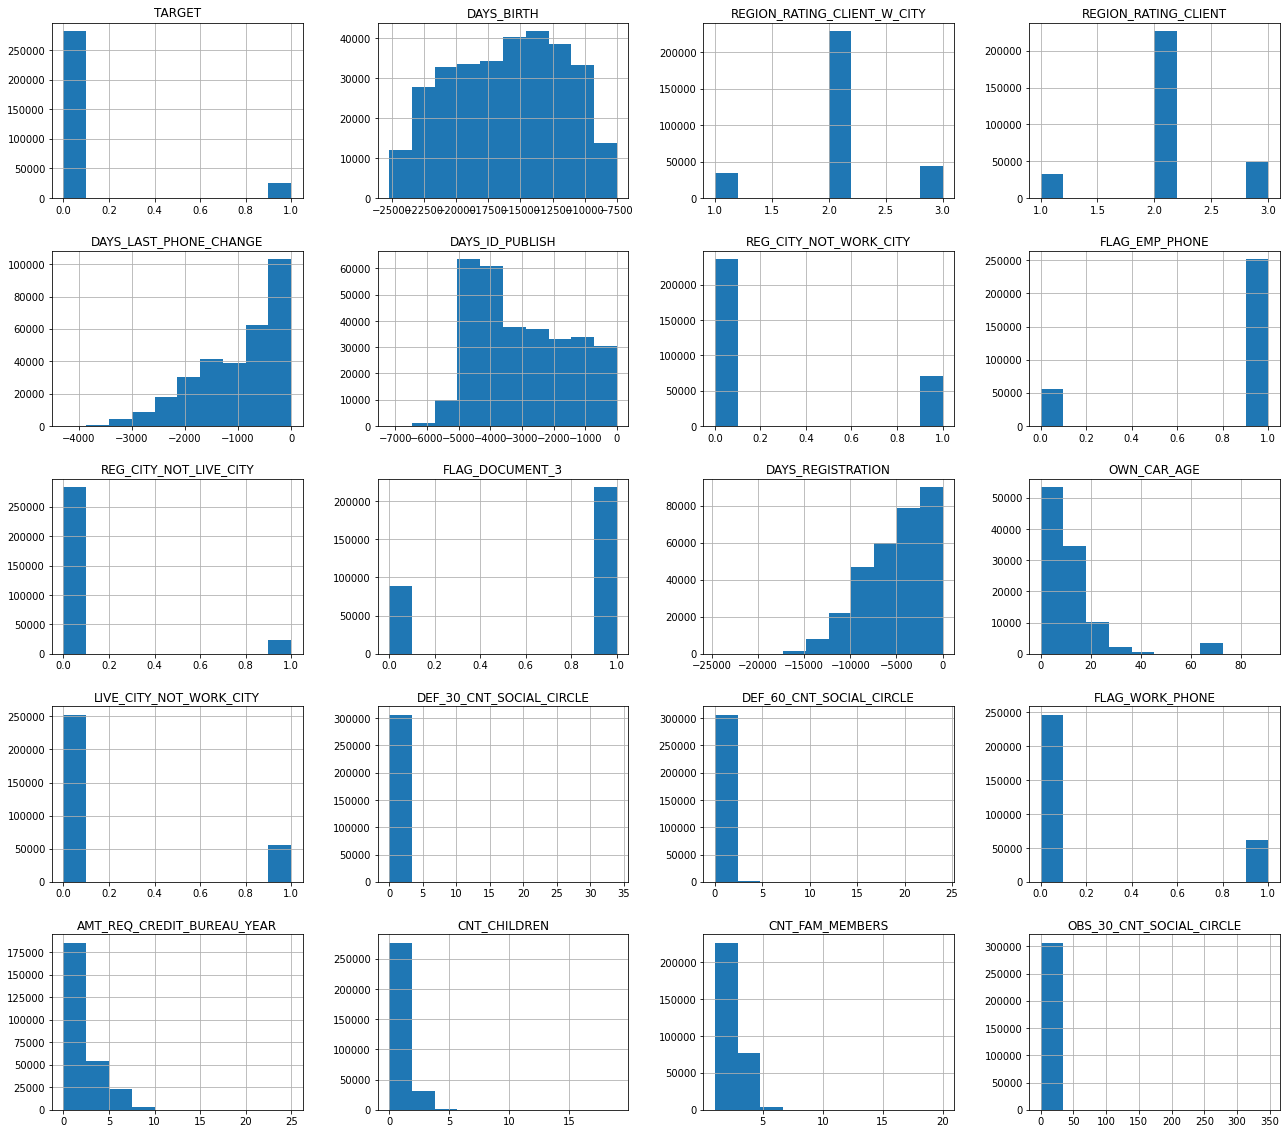

In [26]:
df[df_top20.index.to_list()].hist( figsize = (22, 20) )
plt.show()

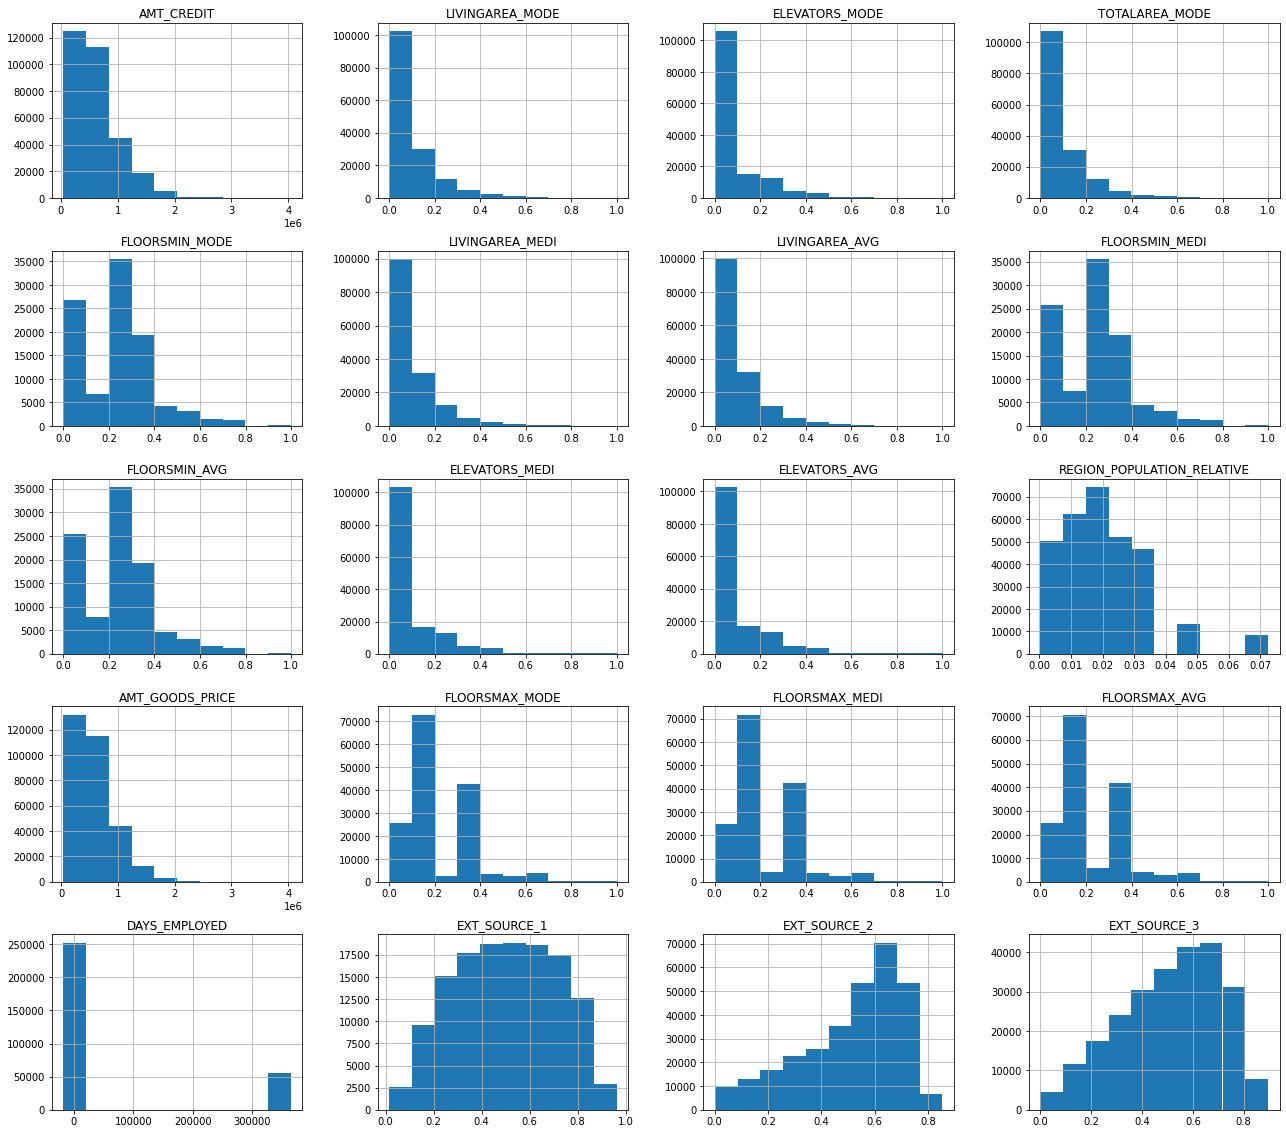

In [27]:
df[df_bottom20.index.to_list()].hist( figsize = (22, 20) )
plt.show()

<AxesSubplot:>

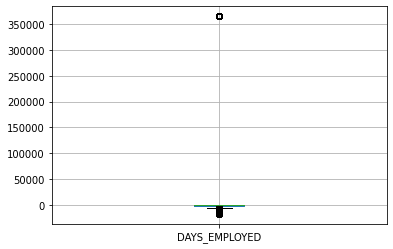

In [28]:
df.boxplot( column =['DAYS_EMPLOYED'], grid = True)

In [29]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

<AxesSubplot:>

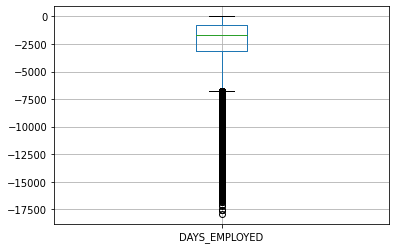

In [30]:
df.boxplot( column =['DAYS_EMPLOYED'], grid = True)

In [31]:
save_file(df, 'application_train_dyemp_cleaned')

Saved /kaggle/working/application_train_dyemp_cleaned.csv...


In [32]:
df_bureau = read_input_file(fileName = 'bureau')
display(get_nan_percentage(df_bureau))
df_bureau_balance = read_input_file(fileName = 'bureau_balance')
#display(get_nan_percentage(df_bureau_balance)) ## No NaNs

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
Loaded bureau... Dataframe contains 1716428


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,Consumer credit,-21,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   SK_ID_CURR              1716428 non-null  int32   
 1   SK_ID_BUREAU            1716428 non-null  int32   
 2   CREDIT_ACTIVE           1716428 non-null  category
 3   CREDIT_CURRENCY         1716428 non-null  category
 4   DAYS_CREDIT             1716428 non-null  int16   
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int16   
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float16 
 7   DAYS_ENDDATE_FACT       1082775 non-null  float16 
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-null   float32 
 9   CNT_CREDIT_PROLONG      1716428 non-null  int8    
 10  AMT_CREDIT_SUM          1716415 non-null  float32 
 11  AMT_CREDIT_SUM_DEBT     1458759 non-null  float32 
 12  AMT_CREDIT_SUM_LIMIT    1124648 non-null  float32 
 13  AMT_CREDIT_SUM_OVERDUE  1716428 non-null  

None

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0000,278214.9336,102938.5581,100001.0000,188866.7500,278055.0000,367426.0000,456255.0000
SK_ID_BUREAU,1716428.0000,5924434.4890,532265.7286,5000000.0000,5463953.7500,5926303.5000,6385681.2500,6843457.0000
DAYS_CREDIT,1716428.0000,-1142.1077,795.1649,-2922.0000,-1666.0000,-987.0000,-474.0000,0.0000
CREDIT_DAY_OVERDUE,1716428.0000,0.8182,36.5444,0.0000,0.0000,0.0000,0.0000,2792.0000
DAYS_CREDIT_ENDDATE,1610875.0000,NaN,NaN,-42048.0000,-1138.0000,-330.0000,474.0000,31200.0000
DAYS_ENDDATE_FACT,1082775.0000,NaN,NaN,-42016.0000,-1489.0000,-897.0000,-425.0000,0.0000
AMT_CREDIT_MAX_OVERDUE,591940.0000,3825.4172,206031.6094,0.0000,0.0000,0.0000,0.0000,115987184.0000
CNT_CREDIT_PROLONG,1716428.0000,0.0064,0.0962,0.0000,0.0000,0.0000,0.0000,9.0000
AMT_CREDIT_SUM,1716415.0000,354994.6250,1149811.3750,0.0000,51300.0000,125518.5000,315000.0000,585000000.0000
AMT_CREDIT_SUM_DEBT,1458759.0000,137085.1406,677401.1250,-4705600.5000,0.0000,0.0000,40153.5000,170100000.0000


Saved /kaggle/working/bureau.csv...


,column,percent
16,AMT_ANNUITY,71.4735
8,AMT_CREDIT_MAX_OVERDUE,65.5133
7,DAYS_ENDDATE_FACT,36.9170
12,AMT_CREDIT_SUM_LIMIT,34.4774
11,AMT_CREDIT_SUM_DEBT,15.0119
6,DAYS_CREDIT_ENDDATE,6.1496
10,AMT_CREDIT_SUM,0.0008


Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Loaded bureau_balance... Dataframe contains 27299925


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype   
---  ------          --------------     -----   
 0   SK_ID_BUREAU    27299925 non-null  int32   
 1   MONTHS_BALANCE  27299925 non-null  int8    
 2   STATUS          27299925 non-null  category
dtypes: category(1), int32(1), int8(1)
memory usage: 156.2 MB


None

,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0000,6036297.3330,492348.8569,5001709.0000,5730933.0000,6070821.0000,6431951.0000,6842888.0000
MONTHS_BALANCE,27299925.0000,-30.7417,23.8645,-96.0000,-46.0000,-25.0000,-11.0000,0.0000


Saved /kaggle/working/bureau_balance.csv...


In [33]:
#plot_categroical_variables(df_bureau, include_target=False) 

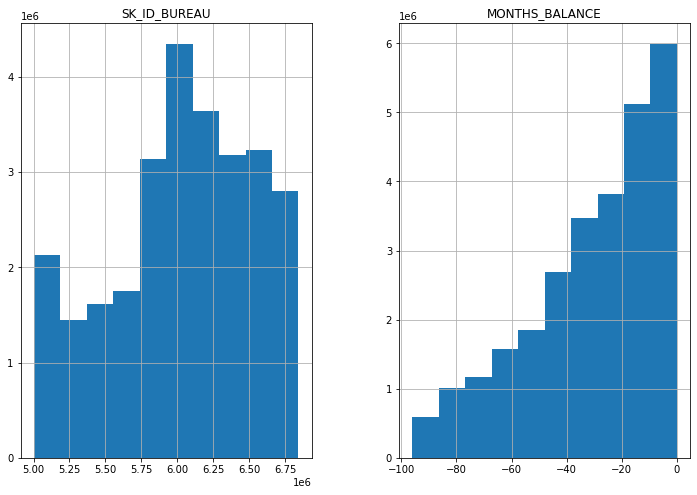

In [34]:
#df_bureau.hist( figsize = (22, 20) )
#plt.show()
df_bureau_balance.hist(figsize = (12, 8) ) #figsize = (22, 20) 
plt.show()

In [35]:
get_nan_percentage(df_bureau)

,column,percent
16,AMT_ANNUITY,71.4735
8,AMT_CREDIT_MAX_OVERDUE,65.5133
7,DAYS_ENDDATE_FACT,36.9170
12,AMT_CREDIT_SUM_LIMIT,34.4774
11,AMT_CREDIT_SUM_DEBT,15.0119
6,DAYS_CREDIT_ENDDATE,6.1496
10,AMT_CREDIT_SUM,0.0008


In [36]:
len(df_bureau_balance)
bb, categorical_cols = one_hot_encoder(df_bureau_balance, nan_as_category= False)

In [37]:
categorical_cols

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X']

In [38]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


In [39]:
# Calculate rate for each category with decay
bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
len(bb_processed)

817395

In [40]:
bb_processed.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5001709,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8866,0.1134
1,5001710,0.0602,0.0000,0.0000,0.0000,0.0000,0.0000,0.5783,0.3614
2,5001711,0.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2500
3,5001712,0.5263,0.0000,0.0000,0.0000,0.0000,0.0000,0.4737,0.0000
4,5001713,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [41]:
 # Min, Max, Count and mean duration of payments (months)
agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')

In [42]:
bb_processed.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE
0,5001709,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8866,0.1134,-96,0,-48.0000,97
1,5001710,0.0602,0.0000,0.0000,0.0000,0.0000,0.0000,0.5783,0.3614,-82,0,-41.0000,83
2,5001711,0.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2500,-3,0,-1.5000,4
3,5001712,0.5263,0.0000,0.0000,0.0000,0.0000,0.0000,0.4737,0.0000,-18,0,-9.0000,19
4,5001713,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-21,0,-10.5000,22


In [43]:
## TODO :: Move this to feature engg
"""
# Credit duration and credit/account end date difference
df_bureau['CREDIT_DURATION'] = -df_bureau['DAYS_CREDIT'] + df_bureau['DAYS_CREDIT_ENDDATE']
df_bureau['ENDDATE_DIF'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
# Credit to debt ratio and difference
df_bureau['DEBT_PERCENTAGE'] = df_bureau['AMT_CREDIT_SUM'] / df_bureau['AMT_CREDIT_SUM_DEBT']
df_bureau['DEBT_CREDIT_DIFF'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
df_bureau['CREDIT_TO_ANNUITY_RATIO'] = df_bureau['AMT_CREDIT_SUM'] / df_bureau['AMT_ANNUITY']
"""
# One-hot encoder
df_bureau, categorical_cols = one_hot_encoder(df_bureau, nan_as_category= False)

In [44]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,-131,NaN,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,-20,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,-21,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# Join bureau balance features
df_bureau_combined = df_bureau.merge(bb_processed, how='left', on='SK_ID_BUREAU')

In [46]:
len(df_bureau_combined)

1716428

In [47]:
df_bureau_combined.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE
0,215354,5714462,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,-131,NaN,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,-20,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,-21,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
del df_bureau_combined['SK_ID_BUREAU']

In [49]:
save_file(df_bureau_combined, 'bureau_combined')

Saved /kaggle/working/bureau_combined.csv...


In [50]:
df_bureau_combined_target = df_bureau_combined.merge(df[['SK_ID_CURR', 'TARGET']], how='left', on='SK_ID_CURR')

Saved /kaggle/working/0ytziltt.csv...


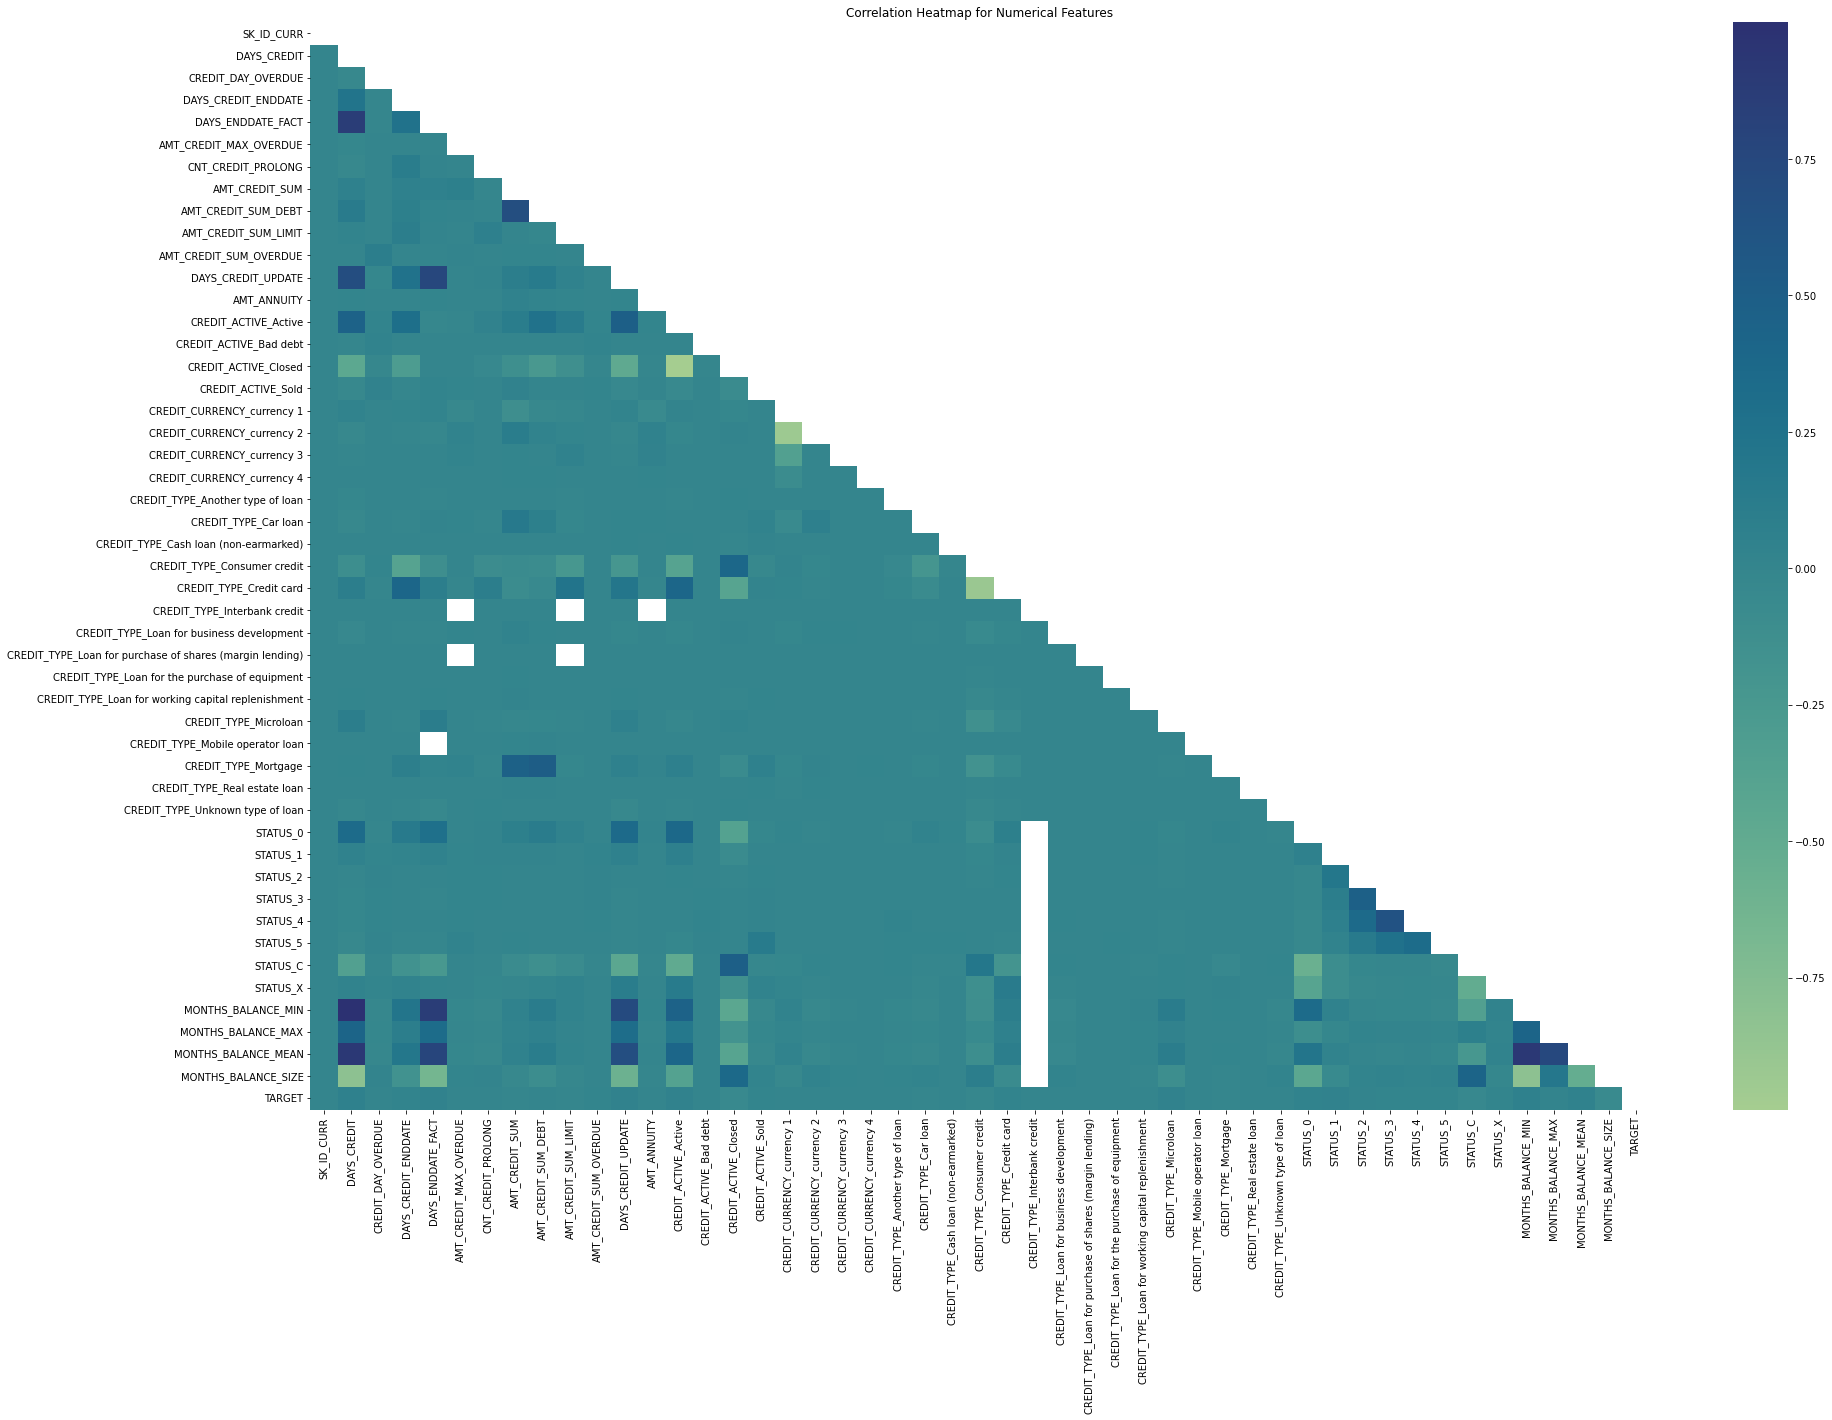

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,TARGET
SK_ID_CURR,1.0000,0.0003,0.0003,0.0005,-0.0006,0.0013,-0.0004,0.0012,-0.0008,-0.0003,-0.0000,0.0005,-0.0027,0.0003,0.0005,0.0000,-0.0025,-0.0008,0.0004,0.0011,0.0007,0.0006,0.0008,-0.0002,-0.0017,0.0019,-0.0010,0.0001,0.0010,0.0005,-0.0007,-0.0014,-0.0005,-0.0006,-0.0002,0.0001,-0.0002,0.0010,0.0014,-0.0005,-0.0011,-0.0018,-0.0011,0.0014,-0.0010,-0.0020,-0.0016,-0.0002,-0.0030
DAYS_CREDIT,0.0003,1.0000,-0.0273,0.2257,0.8754,-0.0147,-0.0305,0.0509,0.1354,0.0251,-0.0004,0.6888,0.0057,0.4536,-0.0045,-0.4484,-0.0328,0.0343,-0.0342,-0.0062,-0.0027,-0.0153,-0.0301,0.0022,-0.1089,0.1047,0.0005,-0.0366,0.0006,-0.0014,0.0102,0.1024,0.0003,0.0099,0.0018,-0.0242,0.3455,0.0442,-0.0107,-0.0157,-0.0119,-0.0285,-0.3516,0.0310,0.9999,0.4216,0.9188,-0.8132,0.0616
CREDIT_DAY_OVERDUE,0.0003,-0.0273,1.0000,-0.0074,-0.0086,0.0012,0.0028,-0.0033,-0.0024,-0.0003,0.0910,-0.0185,-0.0003,0.0207,0.0299,-0.0254,0.0357,0.0006,-0.0006,-0.0002,-0.0001,0.0009,-0.0013,-0.0001,0.0052,-0.0044,-0.0000,-0.0006,-0.0000,-0.0001,-0.0003,-0.0018,-0.0000,-0.0015,-0.0001,-0.0004,-0.0060,0.0055,0.0129,0.0102,0.0101,0.0143,-0.0052,0.0095,-0.0224,-0.0132,-0.0222,0.0157,0.0027
DAYS_CREDIT_ENDDATE,0.0005,0.2257,-0.0074,1.0000,0.2488,0.0006,0.1137,0.0554,0.0813,0.0954,0.0011,0.2485,0.0005,0.2969,-0.0015,-0.2950,-0.0093,0.0061,-0.0056,-0.0025,-0.0001,-0.0017,-0.0108,0.0005,-0.3924,0.4002,-0.0002,-0.0082,0.0001,0.0000,-0.0009,-0.0082,0.0001,0.0837,0.0009,-0.0077,0.1442,0.0220,0.0018,-0.0031,-0.0023,-0.0069,-0.1654,0.0344,0.2073,0.0939,0.1931,-0.1633,0.0265
DAYS_ENDDATE_FACT,-0.0006,0.8754,-0.0086,0.2488,1.0000,0.0010,0.0120,0.0591,0.0196,0.0195,-0.0003,0.7513,0.0063,-0.0196,-0.0008,0.0007,0.0204,0.0209,-0.0211,-0.0031,-0.0001,-0.0052,0.0155,0.0040,-0.1199,0.0927,0.0005,-0.0082,0.0016,-0.0000,0.0085,0.1129,NaN,0.0204,0.0023,-0.0307,0.2781,0.0502,-0.0018,-0.0049,-0.0008,-0.0044,-0.2432,0.0110,0.8710,0.3374,0.7776,-0.6493,0.0391
AMT_CREDIT_MAX_OVERDUE,0.0013,-0.0147,0.0012,0.0006,0.0010,1.0000,0.0015,0.0817,0.0140,-0.0001,0.0150,-0.0007,0.0016,-0.0045,0.0017,0.0034,0.0109,-0.0332,0.0281,0.0216,-0.0000,0.0003,0.0097,-0.0001,-0.0027,-0.0057,NaN,0.0097,NaN,0.0005,0.0001,-0.0009,-0.0000,0.0334,-0.0000,0.0020,-0.0034,0.0070,0.0068,0.0099,0.0063,0.0335,0.0002,-0.0018,-0.0125,-0.0090,-0.0129,0.0079,0.0016
CNT_CREDIT_PROLONG,-0.0004,-0.0305,0.0028,0.1137,0.0120,0.0015,1.0000,-0.0083,-0.0014,0.0738,0.0000,0.0179,-0.0005,0.0365,0.0015,-0.0363,-0.0007,0.0006,-0.0004,-0.0007,-0.0002,-0.0016,-0.0069,-0.0004,-0.0909,0.0998,-0.0001,-0.0019,-0.0001,-0.0002,-0.0011,-0.0043,-0.0001,-0.0062,-0.0003,0.0076,0.0181,0.0160,0.0082,0.0047,0.0018,0.0020,-0.0072,-0.0133,-0.0301,-0.0238,-0.0325,0.0174,0.0015
AMT_CREDIT_SUM,0.0012,0.0509,-0.0033,0.0554,0.0591,0.0817,-0.0083,1.0000,0.6834,0.0038,0.0063,0.1046,0.0491,0.1179,-0.0006,-0.1226,0.0391,-0.1158,0.1207,0.0072,0.0083,-0.0001,0.1636,0.0009,-0.0698,-0.0878,-0.0002,0.0327,0.0040,0.0118,

Top Numerical Correlations


CREDIT_ACTIVE_Closed        CREDIT_ACTIVE_Active          -0.9918
CREDIT_CURRENCY_currency 1  CREDIT_CURRENCY_currency 2    -0.9323
CREDIT_TYPE_Credit card     CREDIT_TYPE_Consumer credit   -0.9078
MONTHS_BALANCE_MIN          MONTHS_BALANCE_SIZE           -0.8134
MONTHS_BALANCE_SIZE         DAYS_CREDIT                   -0.8132
                            DAYS_ENDDATE_FACT             -0.6493
DAYS_CREDIT_UPDATE          MONTHS_BALANCE_SIZE           -0.5812
STATUS_C                    STATUS_0                      -0.5668
MONTHS_BALANCE_MEAN         MONTHS_BALANCE_SIZE           -0.5177
STATUS_X                    STATUS_C                      -0.5088
STATUS_C                    CREDIT_ACTIVE_Active          -0.4838
DAYS_CREDIT_UPDATE          CREDIT_ACTIVE_Closed          -0.4745
CREDIT_ACTIVE_Closed        DAYS_CREDIT                   -0.4484
STATUS_0                    MONTHS_BALANCE_SIZE           -0.4445
STATUS_C                    DAYS_CREDIT_UPDATE            -0.4431
CREDIT_ACT

In [51]:
plot_numerical_variables(df_bureau_combined_target)

In [52]:
df_top20, df_bottom20 = find_corr_with_target(df_bureau_combined_target)

Most Positive Correlations


TARGET                    1.0000
MONTHS_BALANCE_MIN        0.0617
DAYS_CREDIT               0.0616
MONTHS_BALANCE_MEAN       0.0472
CREDIT_ACTIVE_Active      0.0420
DAYS_CREDIT_UPDATE        0.0411
DAYS_ENDDATE_FACT         0.0391
CREDIT_TYPE_Microloan     0.0376
STATUS_1                  0.0364
STATUS_0                  0.0291
DAYS_CREDIT_ENDDATE       0.0265
CREDIT_TYPE_Credit card   0.0203
STATUS_2                  0.0126
MONTHS_BALANCE_MAX        0.0124
STATUS_3                  0.0096
STATUS_4                  0.0096
STATUS_5                  0.0092
AMT_CREDIT_SUM_OVERDUE    0.0063
CREDIT_ACTIVE_Sold        0.0053
STATUS_X                  0.0045
Name: TARGET, dtype: float64



Most Negative Correlations


AMT_ANNUITY                                                 0.0001
CREDIT_TYPE_Mobile operator loan                           -0.0002
CREDIT_TYPE_Interbank credit                               -0.0002
CREDIT_TYPE_Loan for purchase of shares (margin lending)   -0.0005
CREDIT_TYPE_Cash loan (non-earmarked)                      -0.0005
CREDIT_TYPE_Another type of loan                           -0.0006
CREDIT_CURRENCY_currency 4                                 -0.0007
CREDIT_TYPE_Unknown type of loan                           -0.0011
CREDIT_TYPE_Real estate loan                               -0.0012
CREDIT_TYPE_Loan for business development                  -0.0021
SK_ID_CURR                                                 -0.0030
CREDIT_CURRENCY_currency 2                                 -0.0033
AMT_CREDIT_SUM_LIMIT                                       -0.0060
AMT_CREDIT_SUM                                             -0.0106
CREDIT_TYPE_Car loan                                       -0.

In [53]:
df_previous_application =read_input_file(fileName =  'previous_application')

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Loaded previous_application... Dataframe contains 1670214


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4301,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,Y,1,0.0000,0.1829,0.8672,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0000,middle,POS mobile with interest,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6152,607500.0000,679671.0000,NaN,607500.0000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0000,low_action,Cash X-Sell: low,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,Cash loans,15060.7354,112500.0000,136444.5000,NaN,112500.0000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,high,Cash X-Sell: high,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000
3,2819243,176158,Cash loans,47041.3359,450000.0000,470790.0000,NaN,450000.0000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,middle,Cash X-Sell: middle,365243.0000,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,Cash loans,31924.3945,337500.0000,404055.0000,NaN,337500.0000,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int32   
 1   SK_ID_CURR                   1670214 non-null  int32   
 2   NAME_CONTRACT_TYPE           1670214 non-null  category
 3   AMT_ANNUITY                  1297979 non-null  float32 
 4   AMT_APPLICATION              1670214 non-null  float32 
 5   AMT_CREDIT                   1670213 non-null  float32 
 6   AMT_DOWN_PAYMENT             774370 non-null   float32 
 7   AMT_GOODS_PRICE              1284699 non-null  float32 
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  category
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  category
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8    
 12  RATE_DOWN_PAYMENT           

None

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0000,1923089.1353,532597.9587,1000001.0000,1461857.2500,1923110.5000,2384279.7500,2845382.0000
SK_ID_CURR,1670214.0000,278357.1741,102814.8238,100001.0000,189329.0000,278714.5000,367514.0000,456255.0000
AMT_ANNUITY,1297979.0000,15955.1221,14782.1377,0.0000,6321.7798,11250.0000,20658.4199,418058.1562
AMT_APPLICATION,1670214.0000,175233.8594,292779.7500,0.0000,18720.0000,71046.0000,180360.0000,6905160.0000
AMT_CREDIT,1670213.0000,196114.0312,318574.6250,0.0000,24160.5000,80541.0000,216418.5000,6905160.0000
AMT_DOWN_PAYMENT,774370.0000,6697.4014,20921.4961,-0.9000,0.0000,1638.0000,7740.0000,3060045.0000
AMT_GOODS_PRICE,1284699.0000,227847.2188,315396.5625,0.0000,50841.0000,112320.0000,234000.0000,6905160.0000
HOUR_APPR_PROCESS_START,1670214.0000,12.4842,3.3340,0.0000,10.0000,12.0000,15.0000,23.0000
NFLAG_LAST_APPL_IN_DAY,1670214.0000,0.9965,0.0593,0.0000,1.0000,1.0000,1.0000,1.0000
RATE_DOWN_PAYMENT,774370.0000,0.0000,0.0000,-0.0000,0.0000,0.0516,0.1089,1.0000


Saved /kaggle/working/previous_application.csv...


In [54]:
df_previous_application_target = df_previous_application.merge(df[['SK_ID_CURR', 'TARGET']], how='left', on='SK_ID_CURR')

Saved /kaggle/working/d_5in4vb.csv...


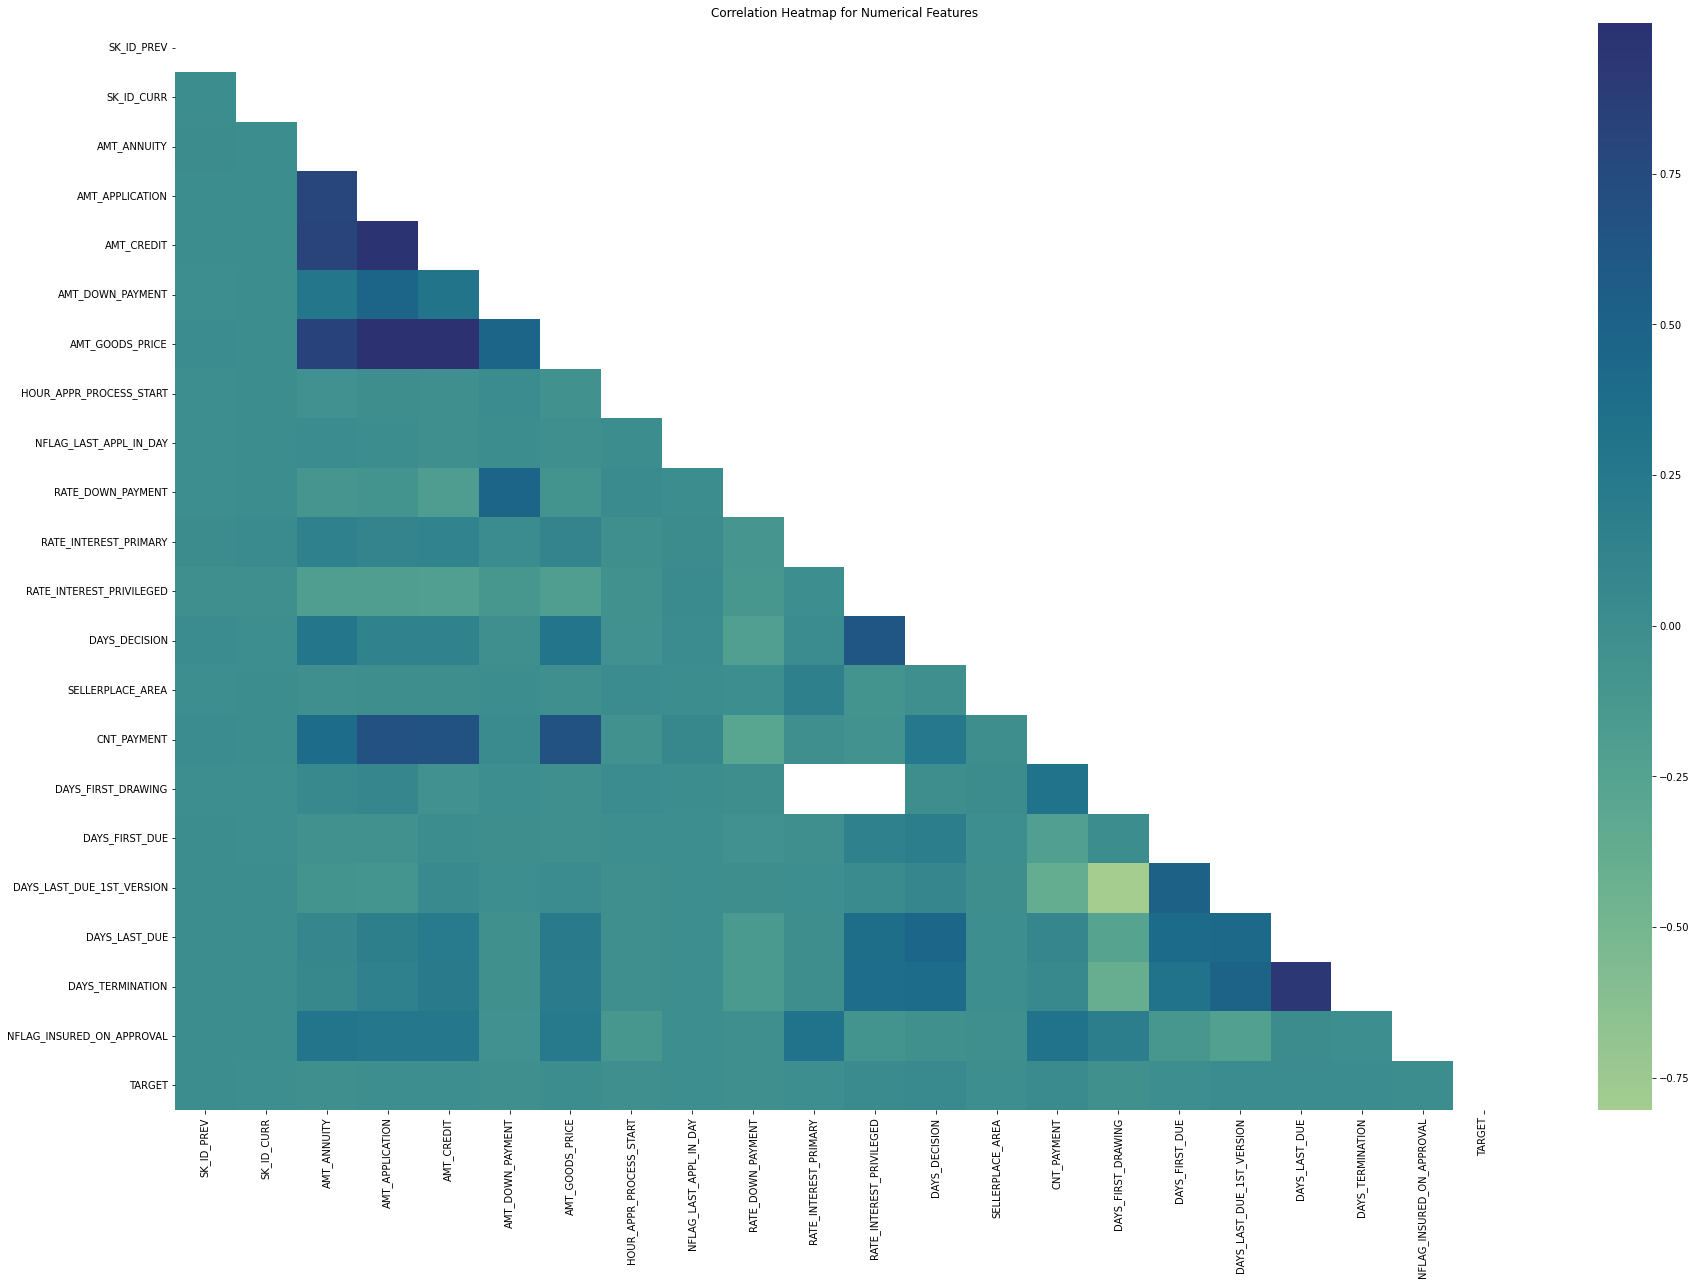

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET
SK_ID_PREV,1.0000,-0.0003,0.0115,0.0033,0.0037,-0.0013,0.0153,-0.0027,-0.0028,-0.0041,0.0130,-0.0223,0.0191,-0.0011,0.0156,-0.0015,-0.0001,0.0012,0.0019,0.0018,0.0040,0.0020
SK_ID_CURR,-0.0003,1.0000,0.0006,0.0003,0.0002,-0.0001,0.0004,0.0028,0.0001,0.0012,0.0332,-0.0168,-0.0006,0.0013,0.0000,-0.0013,-0.0008,0.0003,-0.0003,-0.0000,0.0009,-0.0012
AMT_ANNUITY,0.0115,0.0006,1.0000,0.8089,0.8164,0.2677,0.8209,-0.0362,0.0206,-0.1039,0.1419,-0.2024,0.2791,-0.0150,0.3945,0.0528,-0.0533,-0.0689,0.0827,0.0680,0.2831,-0.0149
AMT_APPLICATION,0.0033,0.0003,0.8089,1.0000,0.9758,0.4828,0.9999,-0.0144,0.0043,-0.0725,0.1100,-0.1998,0.1337,-0.0076,0.6806,0.0745,-0.0495,-0.0849,0.1726,0.1486,0.2592,-0.0056
AMT_CREDIT,0.0037,0.0002,0.8164,0.9758,1.0000,0.3013,0.9931,-0.0210,-0.0252,-0.1881,0.1251,-0.2053,0.1338,-0.0096,0.6743,-0.0368,0.0029,0.0440,0.2248,0.2143,0.2639,-0.0024
AMT_DOWN_PAYMENT,-0.0013,-0.0001,0.2677,0.4828,0.3013,1.0000,0.4828,0.0168,0.0016,0.4739,0.0163,-0.1154,-0.0245,0.0035,0.0317,-0.0018,-0.0136,-0.0009,-0.0314,-0.0307,-0.0426,-0.0169
AMT_GOODS_PRICE,0.0153,0.0004,0.8209,0.9999,0.9931,0.4828,1.0000,-0.0453,-0.0171,-0.0725,0.1100,-0.1998,0.2904,-0.0158,0.6721,-0.0244,-0.0211,0.0169,0.2117,0.2093,0.2434,0.0003
HOUR_APPR_PROCESS_START,-0.0027,0.0028,-0.0362,-0.0144,-0.0210,0.0168,-0.0453,1.0000,0.0058,0.0259,-0.0272,-0.0457,-0.0400,0.0157,-0.0555,0.0143,-0.0028,-0.0166,-0.0180,-0.0183,-0.1173,-0.0278
NFLAG_LAST_APPL_IN_DAY,-0.0028,0.0001,0.0206,0.0043,-0.0252,0.0016,-0.0171,0.0058,1.0000,0.0046,0.0096,0.0246,0.0166,0.0009,0.0633,-0.0004,-0.0023,-0.0020,-0.0023,-0.0007,-0.0071,-0.0029
RATE_DOWN_PAYMENT,-0.0041,0.0012,-0.1039,-0.0725,-0.1881,0.4739,-0.0725,0.0259,0.0046,1.0000,-0.1035,-0.1061,-0.2087,-0.0065,-0.2789,-0.0080,-0.0392,-0.0109,-0.1476,-0.1455,-0.0216,-0.0261


Top Numerical Correlations


DAYS_FIRST_DRAWING        DAYS_LAST_DUE_1ST_VERSION   -0.8035
DAYS_TERMINATION          DAYS_DECISION                0.4002
DAYS_LAST_DUE             DAYS_FIRST_DUE               0.4018
                          DAYS_LAST_DUE_1ST_VERSION    0.4235
                          DAYS_DECISION                0.4485
RATE_DOWN_PAYMENT         AMT_DOWN_PAYMENT             0.4739
AMT_GOODS_PRICE           AMT_DOWN_PAYMENT             0.4828
DAYS_TERMINATION          DAYS_LAST_DUE_1ST_VERSION    0.4932
DAYS_FIRST_DUE            DAYS_LAST_DUE_1ST_VERSION    0.5139
RATE_INTEREST_PRIVILEGED  DAYS_DECISION                0.6316
AMT_GOODS_PRICE           CNT_PAYMENT                  0.6721
AMT_CREDIT                CNT_PAYMENT                  0.6743
AMT_APPLICATION           CNT_PAYMENT                  0.6806
AMT_ANNUITY               AMT_APPLICATION              0.8089
AMT_CREDIT                AMT_ANNUITY                  0.8164
AMT_GOODS_PRICE           AMT_ANNUITY                  0.8209
DAYS_LAS

In [55]:
plot_numerical_variables(df_previous_application_target)

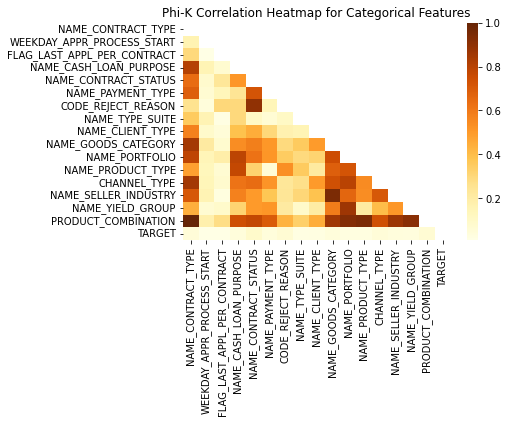

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,TARGET
NAME_CONTRACT_TYPE,1.0000,0.1595,0.2963,0.8083,0.6402,0.6825,0.2571,0.3505,0.5745,0.8470,0.7861,0.4830,0.8490,0.7120,0.4418,1.0000,0.0509
WEEKDAY_APPR_PROCESS_START,0.1595,1.0000,0.0084,0.1546,0.0843,0.0694,0.0395,0.1581,0.0870,0.2125,0.1446,0.1332,0.1417,0.1563,0.0696,0.1774,0.0084
FLAG_LAST_APPL_PER_CONTRACT,0.2963,0.0084,1.0000,0.0742,0.2341,0.1388,0.3011,0.0186,0.0507,0.0781,0.1893,0.0701,0.0814,0.0303,0.0871,0.2776,0.0086
NAME_CASH_LOAN_PURPOSE,0.8083,0.1546,0.0742,1.0000,0.5137,0.2478,0.2976,0.2966,0.3862,0.5428,0.7894,0.7731,0.6175,0.5757,0.3149,0.7417,0.0403
NAME_CONTRACT_STATUS,0.6402,0.0843,0.2341,0.5137,1.0000,0.7216,0.8963,0.1088,0.4482,0.5855,0.6219,0.3220,0.6419,0.5016,0.5022,0.7727,0.0883
NAME_PAYMENT_TYPE,0.6825,0.0694,0.1388,0.2478,0.7216,1.0000,0.1434,0.0607,0.2997,0.5088,0.5153,0.0586,0.5175,0.3704,0.5141,0.6989,0.0398
CODE_REJECT_REASON,0.2571,0.0395,0.3011,0.2976,0.8963,0.1434,1.0000,0.1068,0.1675,0.2937,0.3465,0.5350,0.2345,0.2407,0.2133,0.4292,0.0628
NAME_TYPE_SUITE,0.3505,0.1581,0.0186,0.2966,0.1088,0.0607,0.1068,1.0000,0.1527,0.3495,0.2933,0.3498,0.2712,0.3037,0.0936,0.3309,0.0165
NAME_CLIENT_TYPE,0.5745,0.0870,0.0507,0.3862,0.4482,0.2997,0.1675,0.1527,1.0000,0.4988,0.3172,0.2155,0.5019,0.3836,0.2021,0.4486,0.0218
NAME_GOODS_CATEGORY,0.8470,0.2125,0.0781,0.5428,0.5855,0.5088,0.2937,0.3495,0.4988,1.0000,0.7461,0.6858,0.7378,0.9486,0.5909,0.8567,0.0430


In [56]:
plot_categroical_variables(df_previous_application_target)

In [57]:
df_top20, df_bottom20 = find_corr_with_target(df_previous_application_target)

Most Positive Correlations


TARGET                       1.0000
DAYS_DECISION                0.0399
CNT_PAYMENT                  0.0305
RATE_INTEREST_PRIVILEGED     0.0286
DAYS_LAST_DUE_1ST_VERSION    0.0180
DAYS_LAST_DUE                0.0175
DAYS_TERMINATION             0.0170
SK_ID_PREV                   0.0020
NFLAG_INSURED_ON_APPROVAL    0.0007
AMT_GOODS_PRICE              0.0003
SK_ID_CURR                  -0.0012
RATE_INTEREST_PRIMARY       -0.0015
AMT_CREDIT                  -0.0024
SELLERPLACE_AREA            -0.0025
NFLAG_LAST_APPL_IN_DAY      -0.0029
AMT_APPLICATION             -0.0056
DAYS_FIRST_DUE              -0.0067
AMT_ANNUITY                 -0.0149
AMT_DOWN_PAYMENT            -0.0169
RATE_DOWN_PAYMENT           -0.0261
Name: TARGET, dtype: float64



Most Negative Correlations


CNT_PAYMENT                  0.0305
RATE_INTEREST_PRIVILEGED     0.0286
DAYS_LAST_DUE_1ST_VERSION    0.0180
DAYS_LAST_DUE                0.0175
DAYS_TERMINATION             0.0170
SK_ID_PREV                   0.0020
NFLAG_INSURED_ON_APPROVAL    0.0007
AMT_GOODS_PRICE              0.0003
SK_ID_CURR                  -0.0012
RATE_INTEREST_PRIMARY       -0.0015
AMT_CREDIT                  -0.0024
SELLERPLACE_AREA            -0.0025
NFLAG_LAST_APPL_IN_DAY      -0.0029
AMT_APPLICATION             -0.0056
DAYS_FIRST_DUE              -0.0067
AMT_ANNUITY                 -0.0149
AMT_DOWN_PAYMENT            -0.0169
RATE_DOWN_PAYMENT           -0.0261
HOUR_APPR_PROCESS_START     -0.0278
DAYS_FIRST_DRAWING          -0.0312
Name: TARGET, dtype: float64

In [58]:
cat_cols = get_features_of_type(df_previous_application_target)
num_cols = get_features_of_type(df_previous_application_target, is_categorical=False)

In [59]:
len(cat_cols), len(num_cols)

(16, 22)

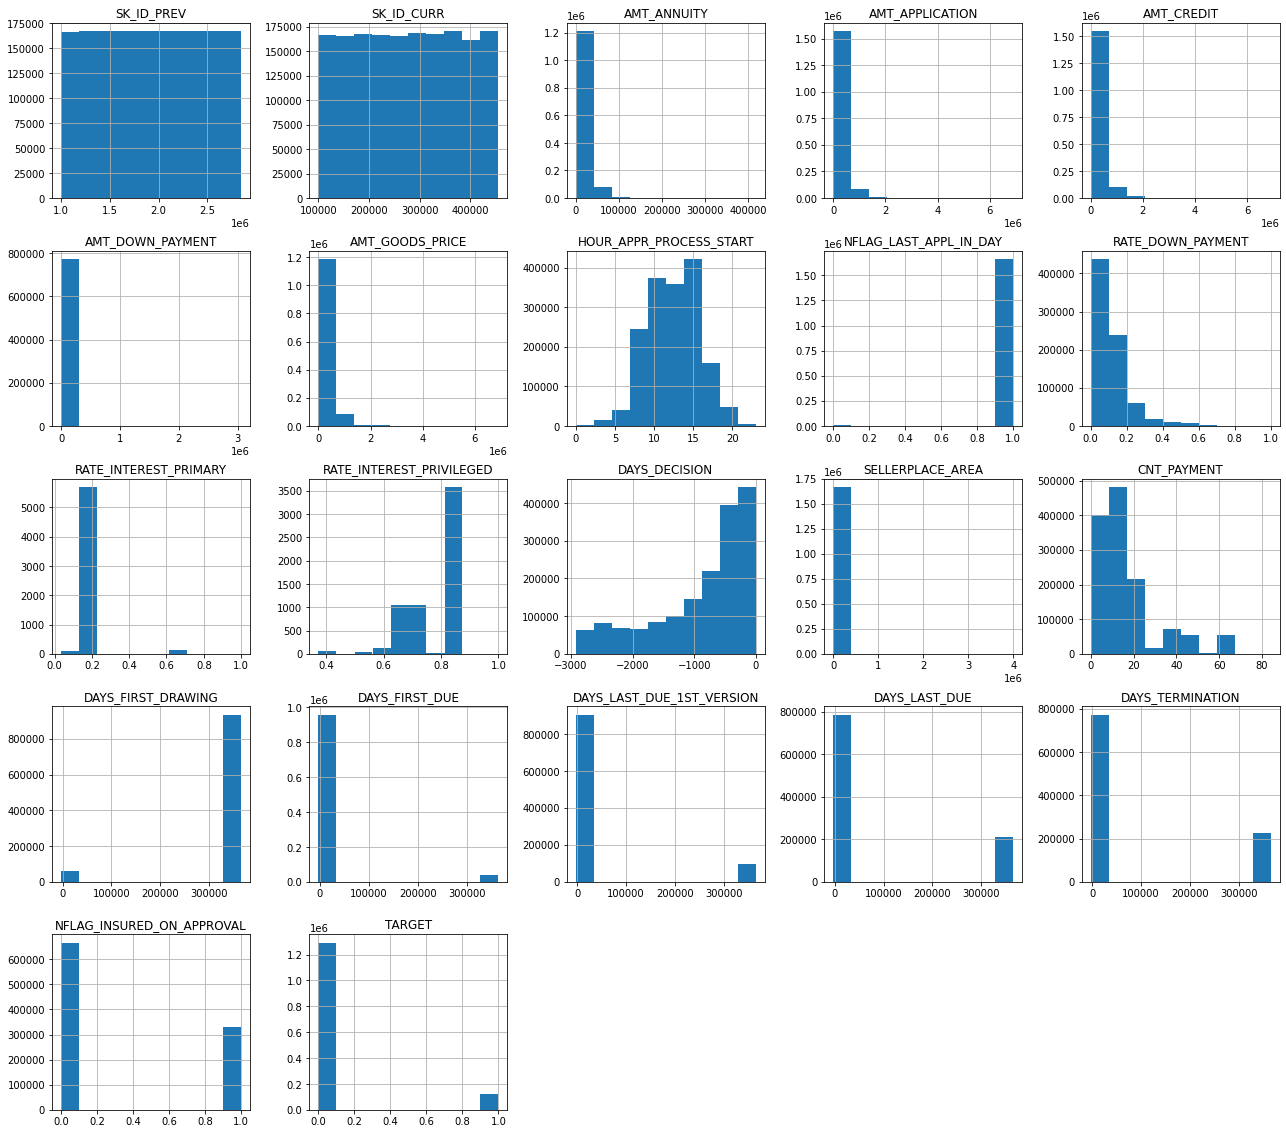

In [60]:
df_previous_application_target[num_cols].hist(figsize = (22, 20) ) #figsize = (22, 20) 
plt.show()

In [61]:
df_previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
df_previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
df_previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
df_previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
df_previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [62]:
save_file(df_previous_application, 'previous_application')

### File exists ! ###
### Removing /kaggle/working/previous_application.csv ###
Saved /kaggle/working/previous_application.csv...


In [63]:
df_POS_CASH_balance = read_input_file(fileName = 'POS_CASH_balance')

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
Loaded POS_CASH_balance... Dataframe contains 10001358


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,Active,0,0
1,1715348,367990,-33,36.0000,35.0000,Active,0,0
2,1784872,397406,-32,12.0000,9.0000,Active,0,0
3,1903291,269225,-35,48.0000,42.0000,Active,0,0
4,2341044,334279,-35,36.0000,35.0000,Active,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Non-Null Count     Dtype   
---  ------                 --------------     -----   
 0   SK_ID_PREV             10001358 non-null  int32   
 1   SK_ID_CURR             10001358 non-null  int32   
 2   MONTHS_BALANCE         10001358 non-null  int8    
 3   CNT_INSTALMENT         9975287 non-null   float16 
 4   CNT_INSTALMENT_FUTURE  9975271 non-null   float16 
 5   NAME_CONTRACT_STATUS   10001358 non-null  category
 6   SK_DPD                 10001358 non-null  int16   
 7   SK_DPD_DEF             10001358 non-null  int16   
dtypes: category(1), float16(2), int16(2), int32(2), int8(1)
memory usage: 171.7 MB


None

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.0000,1903216.5990,535846.5307,1000001.0000,1434405.0000,1896565.0000,2368963.0000,2843499.0000
SK_ID_CURR,10001358.0000,278403.8633,102763.7451,100001.0000,189550.0000,278654.0000,367429.0000,456255.0000
MONTHS_BALANCE,10001358.0000,-35.0126,26.0666,-96.0000,-54.0000,-28.0000,-13.0000,-1.0000
CNT_INSTALMENT,9975287.0000,NaN,0.0000,1.0000,10.0000,12.0000,24.0000,92.0000
CNT_INSTALMENT_FUTURE,9975271.0000,NaN,0.0000,0.0000,3.0000,7.0000,14.0000,85.0000
SK_DPD,10001358.0000,11.6069,132.7140,0.0000,0.0000,0.0000,0.0000,4231.0000
SK_DPD_DEF,10001358.0000,0.6545,32.7625,0.0000,0.0000,0.0000,0.0000,3595.0000


Saved /kaggle/working/POS_CASH_balance.csv...
